# South Korea COVID19 Analysis

## Investigation Overview

> South Korea is one of countries which have dealt with COVID19 very well, the goal of analysis is to analyze what data has been collected and whether there was some specific pattern which helped overcome the disease.

## Dataset Overview

> The dataset is available on kaggle: [Source](https://www.kaggle.com/kimjihoo/coronavirusdataset)


In [72]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
import matplotlib.dates as mdates
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [36]:
# load in the dataset into a pandas dataframe
case_df = pd.read_csv('Data/Case.csv')
patientinfo_df = pd.read_csv('Data/PatientInfo.csv')
patientroute_df = pd.read_csv('Data/PatientRoute.csv')
time_df = pd.read_csv('Data/time.csv')
timeage_df = pd.read_csv('Data/TimeAge.csv')
timegender_df = pd.read_csv('Data/TimeGender.csv')
timeprovince_df = pd.read_csv('Data/TimeProvince.csv')
region_df = pd.read_csv('Data/Region.csv')
weather_df = pd.read_csv('Data/Weather.csv')
searchtrend_df = pd.read_csv('Data/SearchTrend.csv')
policy_df = pd.read_csv('Data/Policy.csv')
region_df.set_index('province', inplace=True)
timeprovince_df.set_index('date', inplace=True)
timeprovince_df.index = pd.to_datetime(timeprovince_df.index)
latest_region = timeprovince_df[timeprovince_df.index=='2020-05-31']
latest_region = latest_region.reset_index()
latest_region.drop(['date','time'], axis=1, inplace=True)
regions_combined = region_df.groupby('province').agg({'elementary_school_count':['sum'],
                                  'kindergarten_count':['sum'],
                                  'elderly_population_ratio':['mean']})
regions_combined.reset_index(inplace=True)
regions_data = regions_combined.set_index('province').join(latest_region.set_index('province'), how='inner', on='province')
regions_data.reset_index(inplace=True)
regions_data.columns = ['province', 'elementary_schools', 'kindergartens', 'elderly_population_ratio','confirmed','released','deceased']
regions_data = regions_data.join(region_df[region_df.index==region_df['city']][['latitude','longitude']], on='province')

## Confirmed COVID19 cases in South Korea

> The first visualisation shows confirmed cases of COVID19 in South Korea, where the worst growth has been noticed by the end of February 2020. 

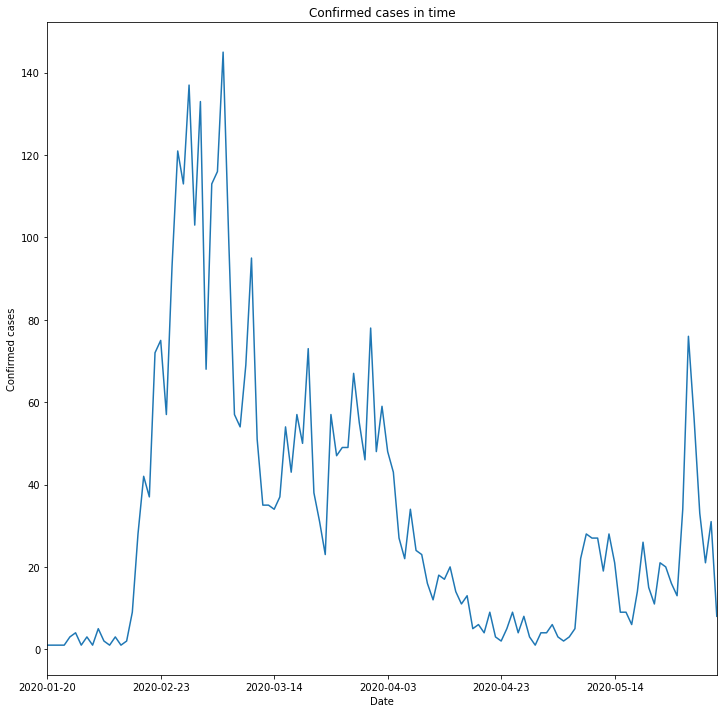

In [70]:
plt.figure(figsize=(12,12))
daily_count = patientinfo_df.groupby('confirmed_date').patient_id.count()
daily_count.plot();
plt.xlabel('Date')
plt.ylabel('Confirmed cases')
plt.title('Confirmed cases in time');

## COVID19 in South Korea provinces

> It's clear that South Korea has been struggling with COVID19 in it's western side. The confirmed cases from Daegu and Gyeongbuk are much higher than in any other province across the country. 

In [78]:
southkorea = folium.Map(location=[36.55, 126.983333], zoom_start=7)
for lat, lon, province, confirmed in zip(regions_data['latitude'], regions_data['longitude'], 
                                         regions_data['province'], regions_data['confirmed']):
    folium.CircleMarker([lat,lon],
                       radius = confirmed/(regions_data['confirmed'].sum())*70,
                       color='red',
                       popup=('Province: '+province+"<br>"),
                       fill_color='orange',
                       fill_opacity=0.5).add_to(southkorea)
southkorea.save('sk-map.html')

In [108]:
from IPython.display import IFrame
IFrame(src='sk-map.html', width=1080, height='600')

## Number of confirmed cases and alerts

> South Korea has quickly introduced alerts and social distancing policies to avoid spreading the COVID19 disease. As the chart suggests self-quarantine might have slightly decreased amount of infected people by the carriers. South Korea has gone even one step further, introducing electronic bands to measure and control the spread of covid.


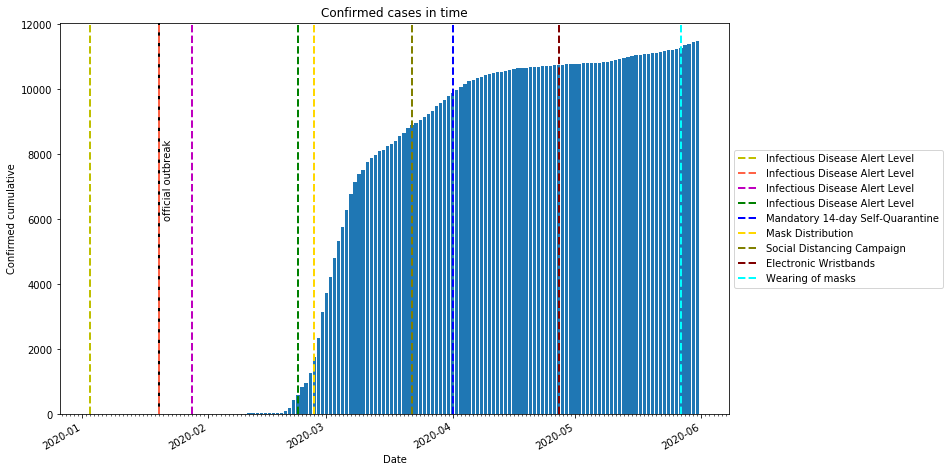

In [106]:
def format_date(ax):
    days = mdates.DayLocator()
    months = mdates.MonthLocator()  # every month
    dayFmt = mdates.DateFormatter('%D')
    monthFmt = mdates.DateFormatter('%Y-%m')
    ax.figure.autofmt_xdate()
    ax.xaxis.set_major_locator(months) 
    ax.xaxis.set_major_formatter(monthFmt)
    ax.xaxis.set_minor_locator(days)
    
def stack_bar(df, ax, legend, **kwargs):
    P = []
    lastBar = None

    for col in df.columns:
        X = df.index
        Y = df[col]
        if lastBar is not None:
            P.append(ax.bar(X, Y, bottom=lastBar, **kwargs))
        else:
            P.append(ax.bar(X, Y, **kwargs))
        lastBar = Y
    if(legend):
        plt.legend([p[0] for p in P], df.columns)
        
colors = ['y','tomato','m','g','b','gold', 'olive', 'maroon', 'aqua']
fig, ax = plt.subplots(1, figsize=(12,8))
stack_bar(time_df[['confirmed']],ax, False)
format_date(ax)
plt.axvline(pd.to_datetime('2020-01-20'), color='black', linestyle='-', lw=2)
plt.text(pd.to_datetime('2020-01-21'), ax.get_ylim()[1]/2 ,'official outbreak', color='black', rotation=90)
ind=0
for index,row in policy_df[policy_df['policy_id'].isin([1,2,3,4,18,27,29,52,57])][['gov_policy','start_date']].iterrows():
    plt.axvline(pd.to_datetime(row['start_date']), color=colors[ind], linestyle='--', lw=2, label=row['gov_policy'])
    #plt.text(pd.to_datetime(row['start_date']), ax.get_ylim()[1] ,row['gov_policy'], color=colors[ind], rotation=90, verticalalignment='center')
    ind+=1
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.title("Confirmed cases in time")
plt.xlabel('Date')
plt.ylabel("Confirmed cumulative")
plt.show()